## Particle within radius or overlap calculations

In [3]:
#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist


#plots
import pylab as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns

#misc
import time
np.set_printoptions(suppress=True)

In [4]:
# set_number = 5
dir_save = '../../data/Sprints/AN/'
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/LowRes/'
df = pd.read_hdf(dir+'NotWindy_ExpectedPP.h5')
# df = pd.read_hdf(dir+'NotWindy_Expected.h5')

In [3]:
# df = pd.concat([df1,df2[6001:],df3[6001:]], ignore_index=True)
# df = pd.read_hdf(dir+'Run05/Run05_InterpolatedX.hdf')

# df.reset_index(inplace=True, drop=True) 

In [4]:
df = df.drop(columns=['mock'])

In [5]:
df.keys()

Index(['master_time', 'xsrc', 'ysrc', 'odor', 'trisonica_u', 'trisonica_v',
       'trisonica_pressure', 'trisonica_temperature', 'gps_linear_x',
       'gps_linear_y', 'gps_linear_z', 'imu_angular_x', 'imu_angular_y',
       'imu_angular_z', 'imu_linear_acc_x', 'imu_linear_acc_y',
       'imu_linear_acc_z', 'U', 'V', 'D', 'S2', 'mock',
       'distance_along_streakline', 'nearest_from_streakline',
       'distance_from_source', 'relative_parallel_comp',
       'relative_perpendicular_comp', 'time'],
      dtype='object')

In [4]:
df = df.drop(columns=['mock','sync_time', 'distance_along_streakline', 'nearest_from_streakline', 'distance_from_source', 'relative_motion'])

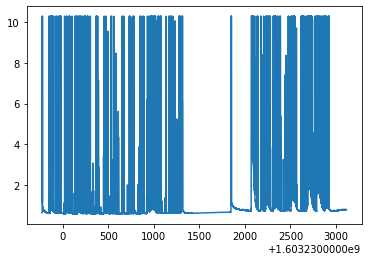

In [8]:
plt.plot(df.master_time, df.odor)

### Calculate Expected encounters

In [19]:
sync_time = df.time
dt=df.master_time[1]-df.master_time[0]
# df.insert(1,'sync_time',sync_time)

# storing the odor location in a numpy array to avoid reading pandas
source = np.array([[0,0]])
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df.xsrc))]) 

distance_from_source = np.array([cdist(odor_position,source)]).flatten()

### Is Encountered odor particle within the Calculated particle radius?

The loop below computes locations of the eastwest and northsouth particles and compares with a radius (distance) to interpret if the encountered particle were close to calculated particle. The execution for the loop is 23.56 seconds for 59770 rows of data

For stationery wind sensor: The loop below takes in ith eastwest and subtracts the ith U and V elements to get the i-1 state, as the eastwest is summation of all the wind positions. 

[3 + 2 + 1] = [6]

hence ith _state = 6

_state = _state-3

_state = _state-2




In [9]:
perp = []
paral = []
def relative_components(streakline_slope,sensor_dir,wind_dir,wind_speed,sensor_speed):
    ## perpendicular component
    wind_perpendicular_comp = np.sin(wrapped_angular_diff(streakline_slope,wind_dir))*wind_speed
    sensor_perpendicular_comp = np.sin(wrapped_angular_diff(streakline_slope,sensor_dir))*sensor_speed
    perp.append(wind_perpendicular_comp-sensor_perpendicular_comp)
    ## parallel component
    wind_parallel_comp = np.cos(wrapped_angular_diff(streakline_slope,wind_dir))*wind_speed
    sensor_parallel_comp = np.cos(wrapped_angular_diff(streakline_slope,sensor_dir))*sensor_speed
    paral.append(wind_parallel_comp-sensor_parallel_comp)
    

In [10]:
def wrapped_angular_diff(a, b):
    return np.arctan2(np.sin(a-b), np.cos(a-b))

def tangent_slope_direction(slope, x): 
    if (x >= 0):
        return slope
    else:
        if (slope > 0):
            return(3.14159265359 - slope)            
        else:
            return(-3.14159265359-(slope))
        
def relative_magnitude_calculation(i):
    wind_speed_magnitude = np.linalg.norm([df.U[i],df.V[i]])
    sensor_speed_magnitude = np.linalg.norm([df.gps_linear_x[i],df.gps_linear_y[i]])
#     relative_speed.append(wind_speed_magnitude - sensor_speed_magnitude)
    return wind_speed_magnitude, sensor_speed_magnitude

In [11]:
def relative_direction_calculation(streakline, pos, i):
    ## get the tangent from the nearest point
    if(pos == 0):
        x = streakline[pos:(pos+2),0]
        y = streakline[pos:(pos+2),1]
    else:
        x = streakline[(pos-1):(pos+2),0]
        y = streakline[(pos-1):(pos+2),1]
    slope_streakline,intercept_streakline=np.polyfit(x,y,1)
    
    streakline_slope=tangent_slope_direction(np.arctan(slope_streakline),streakline[pos,0] )
    ## find direction - source location
    sensor_dir = np.arctan2(df.gps_linear_y[i],df.gps_linear_x[i])
    wind_dir = np.arctan2(df.V[i],df.U[i])
    wind_speed, sensor_speed = relative_magnitude_calculation(i)
    
    relative_components(streakline_slope,sensor_dir,wind_dir,wind_speed,sensor_speed)
    
#     relative_direction.append(wrapped_angular_diff(wind_slope_direction,sensor_dir))
    

In [12]:
def compute_distance(streakline, odor_position,i):
    source = np.array([[0,0]])
    streakline = np.concatenate((streakline,source))
    distance = cdist(odor_position,streakline).flatten()   # cdist compares distance for all the points in both arrays
#     nearest_from_streakline.append(np.min(distance))
    pos = np.where(distance == np.amin(distance))
    relative_direction_calculation(streakline, pos[0][0],i)
    
#     if (len(pos[0]) > 1):
#         length=(np.sqrt(np.sum(np.diff(np.array(streakline[int(pos[0][0]):]), axis=0)**2, axis=1)))
#     else:
#         length=(np.sqrt(np.sum(np.diff(np.array(streakline[int(pos[0]):]), axis=0)**2, axis=1)))
        
#     distance_along_streakline.append(np.sum(length))

In [13]:
def find_streakline():
    eastwest = [np.sum(df.U[j:])*dt for j in range(0,len(df))]
    northsouth = [np.sum(df.V[j:])*dt for j in range(0,len(df))]
    return eastwest,northsouth

In [15]:
# dfx = pd.DataFrame()
# dfx['eastwest']=eastwest
# dfx['northsouth']=northsouth
# dfx.to_hdf(dir+'/Run04Run05_Streakline.h5', key='df', mode='w')

In [20]:
eastwest,northsouth = find_streakline()
# dfx=pd.read_hdf(dir+'Run04Run05_Streakline.h5')
# eastwest=dfx.eastwest
# northsouth=dfx.northsouth

In [21]:
len(eastwest)

29708

In [22]:
# nearest_from_streakline = []
# distance_along_streakline = []

for i in range(len(eastwest)-1, 6000, -1):
    odor_pos = [odor_position[i]] 
    eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
    northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
    wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
    compute_distance(wind_pos,odor_pos,i)

In [23]:
# for i in range(len(eastwest)-1, len(eastwest)-2000, -1):
#     odor_pos = [odor_position[i]] 
#     eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
#     northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
#     wind_pos = np.vstack([eastwest[-6000:],northsouth[-6000:]]).T   
#     compute_distance(wind_pos,odor_pos,i)

In [24]:
#for the section when only the length of the elements is equal to the window value
for i in range((len(eastwest))-1, -1, -1):
    
    odor_pos = [odor_position[i]]  
    if(i == 0):
        radius = np.zeros(1)
        wind_pos = np.array([[0,0]])
        distance = cdist(odor_pos,wind_pos).flatten()
#         slope_sensor = np.arctan2(df.gps_linear_y[i],df.gps_linear_x[i])
        #manual appending for source position 
        #to avoid zeroth error
#         relative_direction.append(0)
#         relative_speed.append(0)
        paral.append(0)
        perp.append(0)
#         distance_along_streakline.append(0)
#         nearest_from_streakline.append(np.min(distance))
        
    else:
        eastwest = np.resize(np.array([eastwest-df.U[i]*dt]),(1,i)).flatten() # resize needed to avoid negative data
        northsouth = np.resize(np.array([northsouth-df.V[i]*dt]),(1,i)).flatten()
        wind_pos = np.vstack([eastwest,northsouth]).T   
        compute_distance(wind_pos,odor_pos,i)



In [25]:
## flip containers because above iteration is done in reverse order
# df['mock'] = np.zeros(len(df))
# distance_along_streakline = np.array(np.flip(distance_along_streakline)) 
# nearest_from_streakline = np.array(np.flip(nearest_from_streakline)) 

# odor_presence = odor_presence[::-1]

## storing in the dataframe 
# df['odor_expected'] = odor_presence
# df['distance_along_streakline'] =  distance_along_streakline
# df['nearest_from_streakline'] = nearest_from_streakline
# df['distance_from_source'] = distance_from_source
df['relative_parallel_comp']=paral[::-1]
df['relative_perpendicular_comp']=perp[::-1]

In [26]:
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/LowRes/'
df.to_hdf(dir+'/Windy_ExpectedPP.h5', key='df', mode='w')

#### Extract Continuous Streakline

In [18]:
dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/'
df = pd.read_hdf(dir+'Run01Run02Run03_Filtered20hz.h5')

In [19]:
df.time[2002]

10.000682830810547

In [20]:
time_res=2002*5 ## 50 seconds for highres 
range_points = []
start_angle=df.D[0]
range_points.append(0)
i = 0        
while i < (len(df)):
    diff = np.abs(df.D[i] - start_angle)
    if diff >= 60:
        range_points.append(i)
        start_angle=df.D[i+time_res]
        i+=time_res
    else:
        i+=1
        continue

In [21]:
cs=pd.DataFrame()
j = 0
while j < (len(range_points)):
#     print(i)
    if(j < len(range_points)-1):
        cs = cs.append(df[range_points[j]:range_points[j+1]])        
    else:
        cs = cs.append(df[range_points[j]:])
    j+=2
cs.reset_index(inplace=True, drop=True) 


In [22]:
dt=df.time[1]-df.time[0]
time = []
time.append(0)
for i in range(1,len(cs)):
    time.append(time[i-1]+dt)

cs = cs.drop(columns=['time'])
cs['time']=time

In [23]:
cs.keys()

Index(['master_time', 'xsrc', 'ysrc', 'odor', 'trisonica_u', 'trisonica_v',
       'trisonica_pressure', 'trisonica_temperature', 'gps_linear_x',
       'gps_linear_y', 'gps_linear_z', 'imu_angular_x', 'imu_angular_y',
       'imu_angular_z', 'imu_linear_acc_x', 'imu_linear_acc_y',
       'imu_linear_acc_z', 'U', 'V', 'D', 'S2', 'distance_along_streakline',
       'nearest_from_streakline', 'distance_from_source', 'filtered_odor',
       'relative_parallel_comp', 'relative_perpendicular_comp', 'sync_time',
       'time'],
      dtype='object')

In [24]:
cs.to_hdf(dir+'ContinuousNotWindy_Expected20Hz.h5', key='cs', mode='w')